Finally, this notebook corresponds to the final preliminary step; part (e). The idea of this step is to treat the dynamics of part (d) for a more realistic case without perfect phase-matching. We therefore utilize the same fundamental equations$^{[1]}$, and use respective amplitudes defined in *Moses*$^{[2]}$. We utilize Quasi-Phase Matching (QPM) methodology defined in *Norton*$^{[3]}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft

Variables are of increasing importance to parts (d) and (e), and as such, more realistic values will be utilized; corresponding to values $n_k \approx 2$, and angular frequencies on the order of IR light: $\omega_k > (10^{16}Hz)$. In addition, wave-vectors $k$ follow $k_j = \frac{n_j \omega_j}{c}$.

We again define equations for the amplitudes:

$$\frac{dA_s}{dz} = \frac{i\omega_s d_{eff}}{n_s c}A_pA_i^*e^{i\Delta k_{OPA}z}$$

$$\frac{dA_p}{dz} = \frac{i\omega_p d_{eff}}{n_p c}A_sA_ie^{-i\Delta k_{OPA}z}$$

$$\frac{dA_i}{dz} = \frac{i\omega_i d_{eff}}{n_i c}[A_pA_s^*e^{i\Delta k_{OPA}z}+A_{2i}A_i^*e^{i\Delta k_{SHG}z}]$$

$$\frac{dA_{2i}}{dz} = \frac{i\omega_{2i} d_{eff}}{2n_{2i} c}A_i^2e^{-i\Delta k_{SHG}z}$$

With $\Delta k_{OPA}$ = $k(\omega_p) − k(\omega_s) − k(\omega_i)$, and $\Delta k_{SHG}$ = $k(\omega_{2i}) − 2k(\omega_i)$. We take $\Delta k_{OPA} \neq \Delta k_{SHG}$, and $\Delta k_{OPA},$ $\Delta k_{SHG} \neq 0.$ The gain in this example is exactly 10, and most variables defined follow the same methodology as in part (d).

$d_{eff}$ is not taken to be a constant: $d_{eff} = d_{eff}(0)sign(cos(\frac{2\pi}{\Lambda_{OPA}})+cos(\frac{2\pi}{\Lambda_{SHG}}))$, where $\Lambda_{OPA} = \frac{2\pi}{|k_{OPA}|}$, and $\Lambda_{SHG} = \frac{2\pi}{|k_{SHG}|}$ for optimal growth.

Finally, a convenient way to create slight phase mismatches appears to be to set "trivial" frequencies, following the relation $\omega_s + \omega_i = \omega_p$, but with slightly different indexes of refraction. E.g, it follows that 

$$\Delta k_{OPA} = k(\omega_p) − k(\omega_s) − k(\omega_i) \Rightarrow \Delta k_{OPA} = \frac{n_p\omega_p}{c}-\frac{n_s\omega_s}{c}-\frac{n_i\omega_i}{c}$$ 

Meaning that with equal $n$ values, $\Delta k_{OPA} = 0$. I.e, a slight mismatch can be created with slightly different $n$ values, in this case, $(n_s, n_p,n_i,n_{2i}) = (2.01, 2.02, 2, 2.01)$. Similar logic follows for $\Delta k_{SHG}$.

Variables defined below:

In [2]:
d = 1; c = 3.0*10**8
wp = 2*np.pi*c/(1.03*10**-6); ws = 3/5*wp;  wi = wp-ws; w2i = 2*wi #Frequencies

ns = 2.01; n_p = 2.02; ni = 2; n2i = 2.01 #Indexes of refraction. 
#n_p 2.04

ks = ns*ws/c; kp = n_p*wp/c; ki = ni*wi/c; k2i = n2i*w2i/c
delta_k_OPA = np.abs(kp-ks-ki)#*0
delta_k_SHG = np.abs(k2i-2*ki)#*0

Ks = 1j*ws*d/(ns*c)
Kp = 1j*wp*d/(n_p*c)
Ki = 1j*wi*d/(ni*c)
K2i = 1j*w2i*d/(2*n2i*c)
#print(delta_k_OPA)
#print(delta_k_SHG)

As per Noah's suggestion, the actual signum function for $d_{eff}$ will be shown, and later examined by use of its fourier transform.
An RK4 method was developed to speed up processing time (it allows for the creation of a $d_{eff}$ list that can be called back, instead of calculated for each iteration of the inherent diff-eq solver for SciPy). 

Methods and additional variables defined below.

In [3]:
z_max = 3*10**-2
z = np.linspace(0,z_max,10000)
I_s = 2*ns*c*8.9**-12 
I_p = 2*n_p*c*8.9**-12
I_i = 2*ni*c*8.9**-12
I_2i = 2*n2i*c*8.9**-12
As = 0.0001+0.0j; Ap = As*10; Ai = 0.0+0.0j; A2i = 0.0+0.0j #Gain is pretty much the minimum at 10.
y0 = [As, Ap, Ai, A2i]

def RK4(dydx, z, y0):    
    h = (z[1]-z[0])
    h_list = np.full(shape = len(y0), fill_value = h, dtype = float)
    y = np.zeros([len(z+1), len(y0)],dtype = complex) #change order of lens 
    y[0] = y0

    for iters, z_iters in enumerate(z):
        k1 = h_list * dydx(z_iters, y[iters], iters)
        k2 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k1, iters)
        k3 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k2, iters)
        k4 = h_list * dydx(z_iters + h, y[iters] + k3, iters)
        
        if iters == len(z)-1:
            break
        y[iters+1] = y[iters] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return y
d_eff = np.sign(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG)) #np.full(len(z),fill_value = 1) 

def dAdz(z,S,iters):
    As, Ap, Ai, A2i = S
    return  (d_eff[iters]*Ks*Ap*np.conj(Ai)*np.exp(1j*delta_k_OPA*z), 
            d_eff[iters]*Kp*As*Ai*np.exp(-1j*delta_k_OPA*z), 
            d_eff[iters]*Ki*(Ap*np.conj(As)*np.exp(1j*delta_k_OPA*z)+A2i*np.conj(Ai)*
            np.exp(1j*delta_k_SHG*z)), 
            d_eff[iters]*K2i*Ai**2*np.exp(-1j*delta_k_SHG*z))

y_list = RK4(dAdz, z, y0)
As_list = I_s*(np.abs(y_list[:,0])**2)
Ap_list = I_p*(np.abs(y_list[:,1])**2)
Ai_list = I_i*(np.abs(y_list[:,2])**2)
A2i_list = I_2i*(np.abs(y_list[:,3])**2)
zero = np.full(len(z), fill_value = np.amax(As_list)/np.amax(Ap_list))


While messy, the whole signum function will be shown.

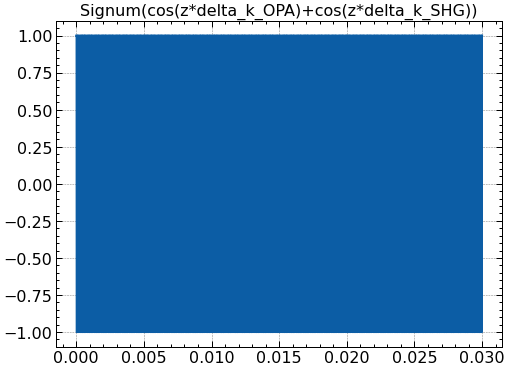

In [4]:
plt.plot(z,np.sign(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG)))
plt.title("Signum(cos(z*delta_k_OPA)+cos(z*delta_k_SHG))")
plt.show()

A satisfactory result of the plot is a frequent changing of the sign of $d_{eff}$, leading to a well-optimized QPM process. However, the actual behavior of the function is apparent upon further analysis. Below, the first hundreth of the prior plot will be graphed:

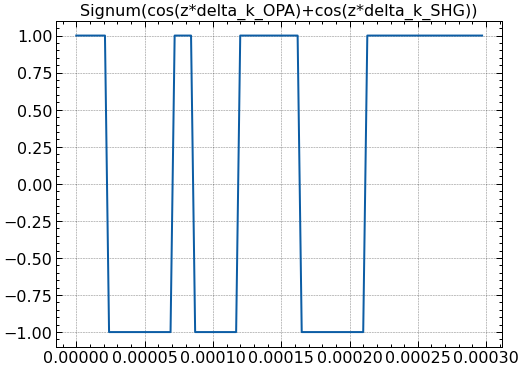

In [5]:
plt.plot(z[:100],np.sign(np.cos(z[:100]*delta_k_OPA)+np.cos(z[:100]*delta_k_SHG)))
plt.title("Signum(cos(z*delta_k_OPA)+cos(z*delta_k_SHG))")
plt.show()

Clearly, the function is no longer a square wave when under the presence of two different phase mismatches.
The fourier transform for the function is plotted below, as well as for its argument (the pair of cosine functions):

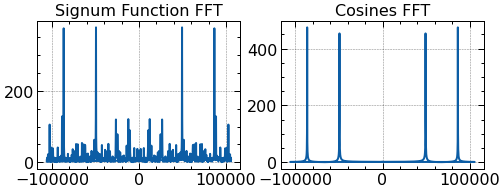

In [15]:
timestep = z_max/20000
r1 = fft(np.sign(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG)))
n1 = r1.size

freq1 = fftfreq(n1, timestep)/np.pi

r2 = fft(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG))
n2 = r2.size

freq2 = fftfreq(n2, timestep)/np.pi

ax1 = plt.subplot(221)          
ax1.plot(freq1,np.abs(r1))
ax1.set_title('Signum Function FFT')

ax2 = plt.subplot(222)
ax2.plot(freq2,np.abs(r2))
ax2.set_title('Cosines FFT')


#plt.plot(freq1,np.abs(y))
#plt.plot(freq2,np.abs(x))
plt.show()

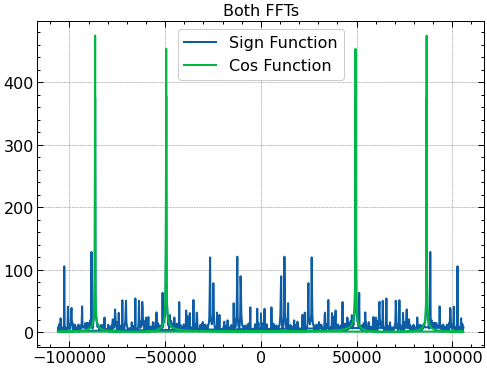

In [16]:
plt.plot(freq1,np.abs(r1))
plt.plot(freq2,np.abs(r2))
plt.title("Both FFTs")
plt.legend(["Sign Function","Cos Function"])
plt.show()

From the chosen variables: $\Delta k_{OPA}  \approx 86000$, and $\Delta k_{SHG}  \approx 49000$.
The plots relay the fact that the cosine function provides a far higher intensity for the characteristic frequencies $\Delta k_{OPA}$, and $\Delta k_{SHG}$. The signum function is far more noisy (understandably, since it isn't a trigonometric function), but is realistic for implementation in the lab.

The actual normalized intensity for each wave is plotted below.

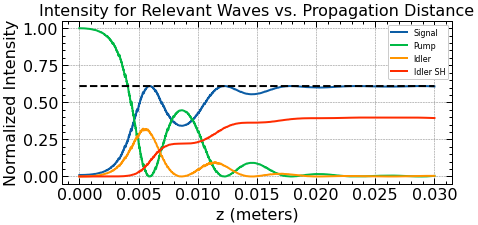

In [8]:
plt.figure(figsize=(7,3))
plt.plot(z,As_list/np.amax(Ap_list))
plt.plot(z,Ap_list/np.amax(Ap_list))
plt.plot(z,Ai_list/np.amax(Ap_list))
plt.plot(z,A2i_list/np.amax(Ap_list))
plt.plot(z,zero,'k--')

plt.xlabel("z (meters)")
plt.ylabel("Normalized Intensity")
plt.legend(["Signal", "Pump", "Idler", "Idler SH"],prop={'size': 8})
plt.title("Intensity for Relevant Waves vs. Propagation Distance")
plt.show()

The most apparent observation is that the behavior of this QPM-dependent system seemingly mimicks a perfectly phase-matched set of equations perfectly. However, one can graph the same plot under perfect phase-matching, and the same z-axis to see a clear difference (next plot below). We take $\Delta k$ values to be 0:

In [9]:
d = 1; c = 3.0*10**8
wp = 2*np.pi*c/(1.03*10**-6); ws = 3/5*wp;  wi = wp-ws; w2i = 2*wi #Frequencies

ns = 2.01; n_p = 2.02; ni = 2; n2i = 2.01 #Indexes of refraction. 
#n_p 2.04

ks = ns*ws/c; kp = n_p*wp/c; ki = ni*wi/c; k2i = n2i*w2i/c
delta_k_OPA = np.abs(kp-ks-ki)*0
delta_k_SHG = np.abs(k2i-2*ki)*0

Ks = 1j*ws*d/(ns*c)
Kp = 1j*wp*d/(n_p*c)
Ki = 1j*wi*d/(ni*c)
K2i = 1j*w2i*d/(2*n2i*c)
# print(2*np.pi/delta_k_OPA*10**6)
# print(2*np.pi/delta_k_SHG*10**6)

In [10]:
z_max = 3*10**-2
z = np.linspace(0,z_max,10000)
I_s = 2*ns*c*8.9**-12 
I_p = 2*n_p*c*8.9**-12
I_i = 2*ni*c*8.9**-12
I_2i = 2*n2i*c*8.9**-12
As = 0.0001+0.0j; Ap = As*10; Ai = 0.0+0.0j; A2i = 0.0+0.0j #Gain is pretty much the minimum at 10.
y0 = [As, Ap, Ai, A2i]

def RK4(dydx, z, y0):    
    h = (z[1]-z[0])
    h_list = np.full(shape = len(y0), fill_value = h, dtype = float)
    y = np.zeros([len(z+1), len(y0)],dtype = complex) #change order of lens 
    y[0] = y0

    for iters, z_iters in enumerate(z):
        k1 = h_list * dydx(z_iters, y[iters], iters)
        k2 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k1, iters)
        k3 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k2, iters)
        k4 = h_list * dydx(z_iters + h, y[iters] + k3, iters)
        
        if iters == len(z)-1:
            break
        y[iters+1] = y[iters] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return y
d_eff = np.sign(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG)) #np.full(len(z),fill_value = 1) 

def dAdz(z,S,iters):
    As, Ap, Ai, A2i = S
    return  (d_eff[iters]*Ks*Ap*np.conj(Ai)*np.exp(1j*delta_k_OPA*z), 
            d_eff[iters]*Kp*As*Ai*np.exp(-1j*delta_k_OPA*z), 
            d_eff[iters]*Ki*(Ap*np.conj(As)*np.exp(1j*delta_k_OPA*z)+A2i*np.conj(Ai)*
            np.exp(1j*delta_k_SHG*z)), 
            d_eff[iters]*K2i*Ai**2*np.exp(-1j*delta_k_SHG*z))

y_list = RK4(dAdz, z, y0)
As_list = I_s*(np.abs(y_list[:,0])**2)
Ap_list = I_p*(np.abs(y_list[:,1])**2)
Ai_list = I_i*(np.abs(y_list[:,2])**2)
A2i_list = I_2i*(np.abs(y_list[:,3])**2)
zero = np.full(len(z), fill_value = np.amax(As_list)/np.amax(Ap_list))

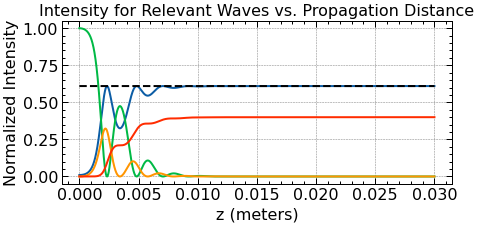

In [11]:
plt.figure(figsize=(7,3))
plt.plot(z,As_list/np.amax(Ap_list))
plt.plot(z,Ap_list/np.amax(Ap_list))
plt.plot(z,Ai_list/np.amax(Ap_list))
plt.plot(z,A2i_list/np.amax(Ap_list))
plt.plot(z,zero,'k--')


plt.xlabel("z (meters)")
plt.ylabel("Normalized Intensity")
plt.title("Intensity for Relevant Waves vs. Propagation Distance")
plt.show()

Upon further analysis, the QPM system follows the same behavior (and even same peak intensities for the signal and SH idler) as the perfectly phase-matched system, but with longer periods. The benefits of perfect phase-matching are clear: the same behavior can be achieved over a lesser propagation distance, but the convenience of QPM provides a very reasonable replacement for the behavior of a perfectly matched set of waves under birefringence.

## References:

[1]: Boyd, Robert W. Nonlinear Optics. San Diego, CA: Academic Press, 2003. Print.

[2]: Jeffrey Moses, Noah Flemens, and Xiaoyue Ding "Back-conversion suppressed parametric frequency conversion for ultrawide bandwidth and ultrahigh efficiency devices", Proc. SPIE 11264, Nonlinear Frequency Generation and Conversion: Materials and Devices XIX, 112640B (2 March 2020); https://doi.org/10.1117/12.2548361

[3]: Andrew H. Norton and C. Martijn de Sterke, "Aperiodic 1-dimensional structures for quasi-phase matching," Opt. Express 12, 841-846 (2004)